<a href="https://colab.research.google.com/github/konamilk/mlb-player-digital-engagement-forecasting/blob/main/MLB_lightGBM_forked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

最初からあったもの
* playerId
* position
* teamId(rosters)
* status(rosters)
* playerBoxScores

追加したもの
* isBirthday


## About Dataset

In [ ]:
%%capture
"""
!pip install pandarallel 

import gc

import numpy as np
import pandas as pd
from pathlib import Path

from pandarallel import pandarallel
pandarallel.initialize()

BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
train = pd.read_csv(BASE_DIR / 'train.csv')

null = np.nan
true = True
false = False

for col in train.columns:

    if col == 'date': continue

    _index = train[col].notnull()
    train.loc[_index, col] = train.loc[_index, col].parallel_apply(lambda x: eval(x))

    outputs = []
    for index, date, record in train.loc[_index, ['date', col]].itertuples():
        _df = pd.DataFrame(record)
        _df['index'] = index
        _df['date'] = date
        outputs.append(_df)

    outputs = pd.concat(outputs).reset_index(drop=True)

    outputs.to_csv(f'{col}_train.csv', index=False)
    outputs.to_pickle(f'{col}_train.pkl')

    del outputs
    del train[col]
    gc.collect()
"""

## Training

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import lightgbm as lgbm
import datetime
import gc

In [ ]:
import sys
from pathlib import Path
if 'google.colab' in sys.modules:
    BASE_DIR = Path('/content/input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('/content/input/mlb-pdef-train-dataset')
elif 'kaggle_web_client' in sys.modules:
    BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('../input/mlb-pdef-train-dataset')

In [ ]:
if 'google.colab' in sys.modules:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json
    !pip install kaggle > /dev/null
    !mkdir input
    # original datasets
    !kaggle competitions download -c mlb-player-digital-engagement-forecasting
    !mkdir input/mlb-player-digital-engagement-forecasting
    !unzip -o '*.zip' -d ./input/mlb-player-digital-engagement-forecasting
    !mv *.csv ./input/mlb-player-digital-engagement-forecasting
    !rm *.zip
    # MLB_PDEF_train_dataset
    !kaggle datasets download -d columbia2131/mlb-pdef-train-dataset
    !mkdir input/mlb-pdef-train-dataset
    !unzip -o '*.zip' -d ./input/mlb-pdef-train-dataset
    !rm *.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘input’: File exists
competition.cpython-37m-x86_64-linux-gnu.so: Skipping, found more recently modified local copy (use --force to force download)
__init__.py: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/3.96M [00:00<?, ?B/s]
100% 3.96M/3.96M [00:00<00:00, 65.3MB/s]
  0% 0.00/3.68k [00:00<?, ?B/s]
100% 3.68k/3.68k [00:00<00:00, 3.18MB/s]
  0% 0.00/824 [00:00<?, ?B/s]
100% 824/824 [00:00<00:00, 792kB/s]
 98% 462M/470M [00:06<00:00, 80.4MB/s]
100% 470M/470M [00:06<00:00, 74.7MB/s]
  0% 0.00/173k [00:00<?, ?B/s]
100% 173k/173k [00:00<00:00, 56.1MB/s]
  0% 0.00/191k [00:00<?, ?B/s]
100% 191k/191k [00:00<00:00, 60.6MB/s]
  0% 0.00/820k [00:00<?, ?B/s]
100% 820k/820k [00:00<00:00, 55.5MB/s]
mkdir: cannot create directory ‘input/mlb-player-digital-engagement-forecasting’: File exists
Archive:  example_test.csv.zip
  inflating: ./input/mlb-player-digital-e

In [ ]:
players = pd.read_csv(BASE_DIR / 'players.csv')
rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl')
targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
scores = pd.read_pickle(TRAIN_DIR / 'playerBoxScores_train.pkl')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [ ]:
p_followers = pd.read_pickle(TRAIN_DIR/'playerTwitterFollowers_train.pkl')
t_followers = pd.read_pickle(TRAIN_DIR/'teamTwitterFollowers_train.pkl')

In [ ]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances','isBirthday', 'playerFollowers', 'teamFollowers']

In [ ]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')


train['date_ym'] = train['date'] // 100
p_followers['date_ym'] = p_followers['date'] // 100
p_followers['playerFollowers'] = p_followers['numberOfFollowers']
train = train.merge(p_followers[['playerId', 'date_ym', 'playerFollowers']], on=['playerId', 'date_ym'], how='left')
p_followers.drop(['date_ym', 'playerFollowers'], axis=1, inplace=True)

t_followers['date_ym'] = t_followers['date'] // 100
t_followers['teamFollowers'] = t_followers['numberOfFollowers']
train = train.merge(t_followers[['teamId', 'date_ym', 'teamFollowers']], on=['teamId', 'date_ym'], how='left')
t_followers.drop(['date_ym', 'teamFollowers'], axis=1, inplace=True)

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

# feature engineering
train['DOB'] = pd.to_datetime(train['DOB'])
train['isBirthday'] = train['date'] % 1000 == train['DOB'].dt.month * 100 + train['DOB'].dt.day


In [ ]:
train_X = train[feature_cols]
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'] < 20210401)
x_train = train_X.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
x_valid = train_X.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)

In [ ]:
gc.collect()

163

In [ ]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}

oof1, model1, score1 = fit_lgbm(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    params
)
oof2, model2, score2 = fit_lgbm(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    params
)
oof3, model3, score3 = fit_lgbm(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    params
)
oof4, model4, score4 = fit_lgbm(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.732834
[200]	valid_0's l1: 0.732834
Early stopping, best iteration is:
[109]	valid_0's l1: 0.732834
mae: 0.73283433423634
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 1.5456
Early stopping, best iteration is:
[46]	valid_0's l1: 1.52938
mae: 1.5293835574233194
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.563552
Early stopping, best iteration is:
[44]	valid_0's l1: 0.563549
mae: 0.5635487956204807
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 1.27575
[200]	valid_0's l1: 1.26342
[300]	valid_0's l1: 1.25795
[400]	valid_0's l1: 1.25712
[500]	valid_0's l1: 1.25712
[600]	valid_0's l1: 1.25712
[700]	valid_0's l1: 1.25712
Early stopping, best iteration is:
[695]	valid_0's l1: 1.25712
mae: 1.2571223147432795
score: 1.0207222505058549


## Inference

In [ ]:
class TestDataset(object):
  def __init__(self, batch_size=5):
    self.current = 0
    self.batch_size = batch_size
    self.df_example_test = pd.read_csv(BASE_DIR/'example_test.csv').set_index('date')
    self.df_example_test['playerTwitterFollowers'].iloc[0] = '[{"date":"2021-05-01","playerId":506433,"playerName":"Yu Darvish","accountName":"Yu Darvish","twitterHandle":"@faridyu","numberOfFollowers":2545509},{"date":"2021-05-01","playerId":545361,"playerName":"Mike Trout","accountName":"Mike Trout","twitterHandle":"@miketrout","numberOfFollowers":2542989}]'
    self.df_example_test['teamTwitterFollowers'].iloc[0] = '[{"date":"2021-05-01","teamId":147,"teamName":"New York Yankees","accountName":"New York Yankees","twitterHandle":"@Yankees","numberOfFollowers":3471801},{"date":"2021-05-01","teamId":112,"teamName":"Chicago Cubs","accountName":"Chicago Cubs","twitterHandle":"@Cubs","numberOfFollowers":2550786},{"date":"2021-05-01","teamId":141,"teamName":"Toronto Blue Jays","accountName":"Toronto Blue Jays","twitterHandle":"@BlueJays","numberOfFollowers":2255947}]'
    self.df_example_sample_submission = pd.read_csv(BASE_DIR/'example_sample_submission.csv').set_index('date')

  def __iter__(self):
    return self

  def __next__(self):
    start = self.current * self.batch_size
    end = (self.current + 1) * self.batch_size
    self.current += 1

    if start >= self.df_example_test.shape[0]:
      raise StopIteration()
    
    return self.df_example_test[start:end], self.df_example_sample_submission[start:end]



In [ ]:
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb
    env = mlb.make_env() # initialize the environment
    iter_test = env.iter_test() # iterator which loops over each date in test set
else:
    iter_test = TestDataset()

for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
    sample_prediction_df = sample_prediction_df.reset_index(drop=True)
    
    # creat dataset
    sample_prediction_df['date'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[0]))
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))

    # Dealing with missing values
    if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
        test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
    else:
        test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in rosters.columns:
            if col == 'playerId': continue
            test_rosters[col] = np.nan
            
    if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
        test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
    else:
        test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in scores.columns:
            if col == 'playerId': continue
            test_scores[col] = np.nan
    test_scores = test_scores.groupby('playerId').sum().reset_index()
    test = sample_prediction_df[['playerId', 'date']].copy()
    test = test.merge(players[players_cols], on='playerId', how='left')
    test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
    test = test.merge(test_scores[scores_cols], on='playerId', how='left')

    test['label_playerId'] = test['playerId'].map(player2num)
    test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
    test['label_teamId'] = test['teamId'].map(teamid2num)
    test['label_status'] = test['status'].map(status2num)

    # Update p_followers, t_followers
    for index, row in test_df.iterrows():
        if row.playerTwitterFollowers == row.playerTwitterFollowers:
            new = pd.DataFrame(eval(row.playerTwitterFollowers)).copy()
            new['date'] = pd.to_datetime(new['date'])
            new['date'] = new['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            new['index'] = index
            p_followers = pd.concat([p_followers, new],axis=0)
            p_followers.reset_index(drop=True)
            del new

        if row.teamTwitterFollowers == row.teamTwitterFollowers:
            new = pd.DataFrame(eval(row.teamTwitterFollowers)).copy()
            new['date'] = pd.to_datetime(new['date'])
            new['date'] = new['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            new['index'] = index
            t_followers = pd.concat([t_followers, new],axis=0)
            t_followers.reset_index(drop=True)
            del new

    test['date_ym'] = test['date'] // 100
    p_followers['date_ym'] = p_followers['date'] // 100
    p_followers['playerFollowers'] = p_followers['numberOfFollowers']
    test = test.merge(p_followers[['playerId', 'date_ym', 'playerFollowers']], on=['playerId', 'date_ym'], how='left')
    p_followers.drop(['date_ym', 'playerFollowers'], axis=1, inplace=True)

    t_followers['date_ym'] = t_followers['date'] // 100
    t_followers['teamFollowers'] = t_followers['numberOfFollowers']
    test = test.merge(t_followers[['teamId', 'date_ym', 'teamFollowers']], on=['teamId', 'date_ym'], how='left')
    t_followers.drop(['date_ym', 'teamFollowers'], axis=1, inplace=True)

    # feature engineering
    test['DOB'] = pd.to_datetime(test['DOB'])
    test['isBirthday'] = test['date'] % 1000 == test['DOB'].dt.month * 100 + test['DOB'].dt.day
    
    test_X = test[feature_cols]
    
    # predict
    pred1 = model1.predict(test_X)
    pred2 = model2.predict(test_X)
    pred3 = model3.predict(test_X)
    pred4 = model4.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
    sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
    sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
    sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
    sample_prediction_df = sample_prediction_df.fillna(0.)
    sample_prediction_df.drop(['playerId', 'date'], axis=1, inplace=True)
    
    if 'kaggle_secrets' in sys.modules:
        env.predict(sample_prediction_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


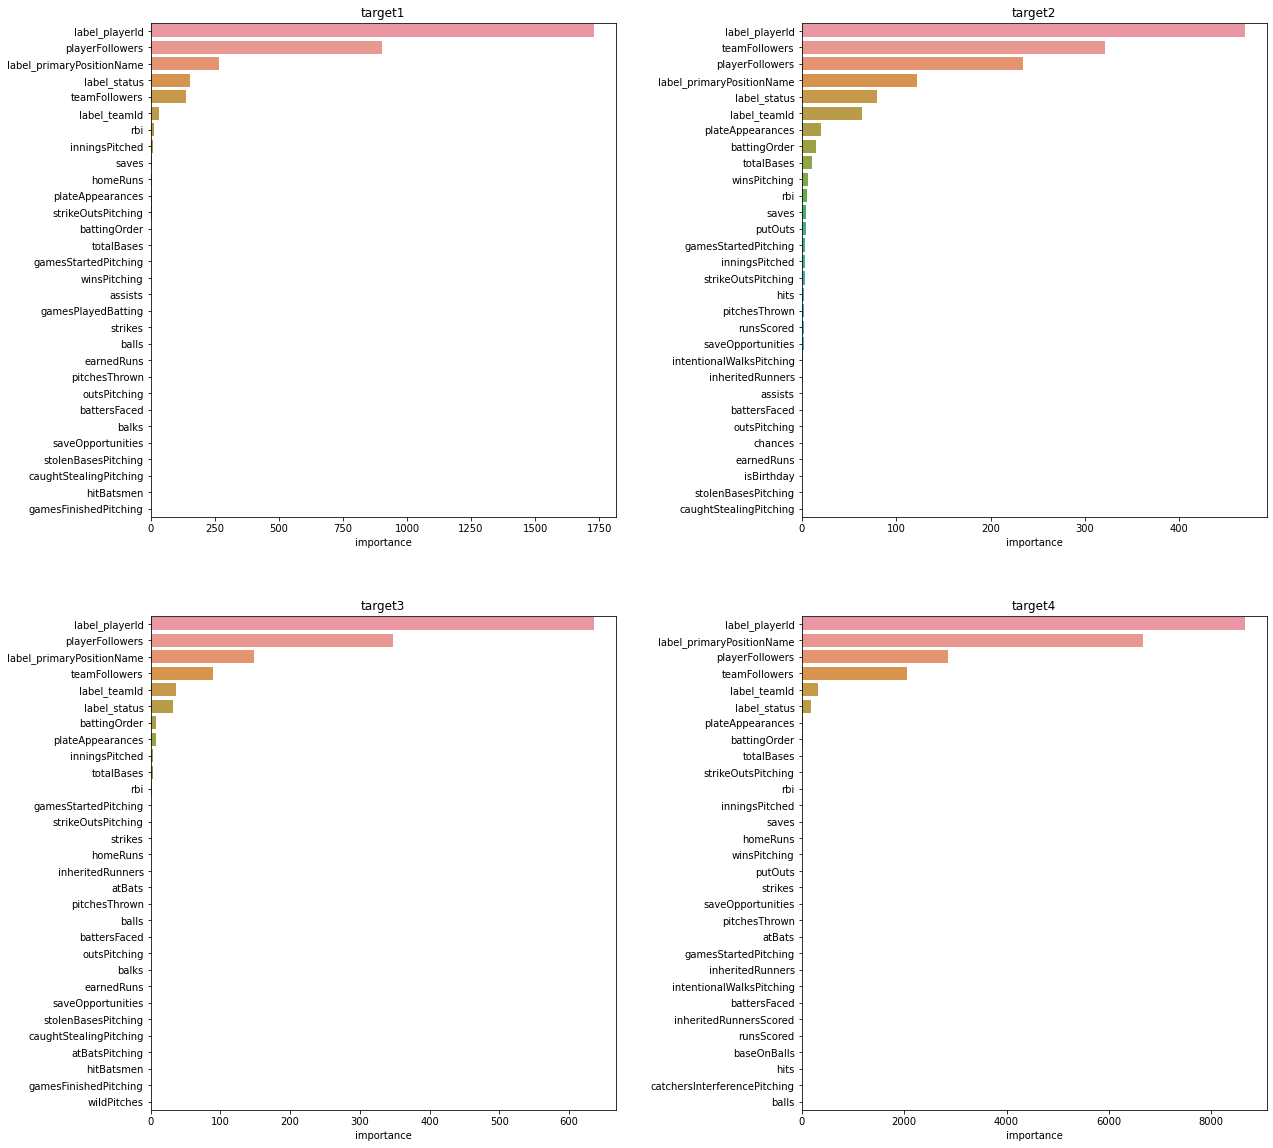

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
models = [model1, model2, model3, model4]

fig, axes = plt.subplots(2, 2, figsize=(20,20))
plt.subplots_adjust(wspace=0.4)
for i, model in enumerate(models):
    data = pd.DataFrame({'importance': model.feature_importances_, 'feature': feature_cols}).sort_values('importance', ascending = False)[0:30]

    ax = axes[ i // 2, i % 2]
    ax.yaxis.label.set_visible(False)
    ax.set_title('target' + str(i+1))
    
    sns.barplot(x='importance', y='feature', data=data, ax=ax)